<a href="https://colab.research.google.com/github/ukokobili/uel_big_data_analytics/blob/main/CN7023_Artificial_Intelligence_%26_Machine_Vision_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from sklearn.metrics import (confusion_matrix, classification_report,
                            roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import label_binarize
import pandas as pd
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Nov 11 19:04:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


### Load Dataset

In [ ]:
class CIFAR10DataLoader:
    """Handles CIFAR-10 data loading"""

    def __init__(self, batch_size=128):
        self.batch_size = batch_size
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck')

        # Advanced data augmentation for training
        self.train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                               (0.2470, 0.2435, 0.2616))
        ])

        # normalization for testing
        self.test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                               (0.2470, 0.2435, 0.2616))
        ])

    def load_data(self):
        """Load CIFAR-10 dataset"""
        train_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=True, download=True,
            transform=self.train_transform
        )

        test_dataset = torchvision.datasets.CIFAR10(
            root='./data', train=False, download=True,
            transform=self.test_transform
        )

        train_loader = DataLoader(train_dataset, batch_size=self.batch_size,
                                shuffle=True, num_workers=2)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size,
                               shuffle=False, num_workers=2)

        print(f"Training samples: {len(train_dataset)}")
        print(f"Testing samples: {len(test_dataset)}")

        return train_loader, test_loader

### Model Architectures

In [ ]:
class CustomCNN(nn.Module):
    """Custom CNN architecture with Batch Normalization and Dropout"""

    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2)
        )

        # Convolutional Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3)
        )

        # Convolutional Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.4)
        )

        # Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class ResidualBlock(nn.Module):
    """Residual block for ResNet-inspired architecture"""

    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                              stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                         stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        out = self.relu(out)
        return out


class ResNetCIFAR(nn.Module):
    """ResNet-inspired architecture for CIFAR-10"""

    def __init__(self, num_classes=10):
        super(ResNetCIFAR, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, 1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class VGGStyleNet(nn.Module):
    """VGG-inspired architecture adapted for CIFAR-10"""

    def __init__(self, num_classes=10):
        super(VGGStyleNet, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


### Training & Evaluation of Models

In [ ]:
class ModelTrainer:
    """Handles model training with advanced techniques"""

    def __init__(self, model, train_loader, test_loader, model_name="Model"):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.model_name = model_name

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.001,
                                   weight_decay=1e-4)

        # Learning rate scheduler
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='max', factor=0.5, patience=5
        )

        self.train_losses = []
        self.train_accs = []
        self.test_losses = []
        self.test_accs = []
        self.best_acc = 0.0

    def train_epoch(self):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        pbar = tqdm(self.train_loader, desc=f'Training {self.model_name}')
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'loss': running_loss/len(pbar),
                            'acc': 100.*correct/total})

        epoch_loss = running_loss / len(self.train_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc

    def evaluate(self):
        """Evaluate on test set"""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(self.test_loader)
        epoch_acc = 100. * correct / total
        return epoch_loss, epoch_acc

    def train_model(self, epochs=50, early_stopping_patience=15):
        """Complete training loop with early stopping"""
        print(f"\n{'*'*60}")
        print(f"Training {self.model_name}")
        print(f"{'*'*60}\n")

        patience_counter = 0
        start_time = time.time()

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            train_loss, train_acc = self.train_epoch()
            test_loss, test_acc = self.evaluate()

            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)
            self.test_losses.append(test_loss)
            self.test_accs.append(test_acc)

            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")

            # Learning rate scheduling
            self.scheduler.step(test_acc)

            # Save best model
            if test_acc > self.best_acc:
                self.best_acc = test_acc
                torch.save(self.model.state_dict(),
                          f'{self.model_name}_best.pth')
                print(f"✓ New best accuracy: {test_acc:.2f}%")
                patience_counter = 0
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= early_stopping_patience:
                print(f"\nEarly stopping triggered after {epoch+1} epochs")
                break

        training_time = time.time() - start_time
        print(f"\nTraining completed in {training_time/60:.2f} minutes")
        print(f"Best Test Accuracy: {self.best_acc:.2f}%")

        return self.best_acc

    def get_predictions(self):
        """Get all predictions for confusion matrix"""
        self.model.eval()
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs = inputs.to(device)
                outputs = self.model(inputs)
                _, predicted = outputs.max(1)

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())

        return np.array(all_labels), np.array(all_preds)

### Visulisation & Analysis on Model Performance

In [ ]:
class ResultsAnalyzer:
    """Handles visualization and analysis of results"""

    def __init__(self, classes):
        self.classes = classes

    def plot_training_history(self, trainers):
        """Plot training history for all models"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))

        # Loss plot
        for trainer in trainers:
            axes[0].plot(trainer.train_losses, label=f'{trainer.model_name} Train')
            axes[0].plot(trainer.test_losses, label=f'{trainer.model_name} Test',
                        linestyle='--')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training and Test Loss')
        axes[0].legend()
        axes[0].grid(True)

        # Accuracy plot
        for trainer in trainers:
            axes[1].plot(trainer.train_accs, label=f'{trainer.model_name} Train')
            axes[1].plot(trainer.test_accs, label=f'{trainer.model_name} Test',
                        linestyle='--')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy (%)')
        axes[1].set_title('Training and Test Accuracy')
        axes[1].legend()
        axes[1].grid(True)

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, model_name):
        """Plot confusion matrix"""
        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.classes, yticklabels=self.classes)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'confusion_matrix_{model_name}.png', dpi=300,
                   bbox_inches='tight')
        plt.show()

    def generate_classification_report(self, y_true, y_pred, model_name):
        """Generate and print classification report"""
        report = classification_report(y_true, y_pred,
                                      target_names=self.classes,
                                      digits=4)
        print(f"\n{'*'*60}")
        print(f"Classification Report - {model_name}")
        print(f"{'*'*60}\n")
        print(report)

        # Save to file
        with open(f'classification_report_{model_name}.txt', 'w') as f:
            f.write(report)

    def compare_models(self, results):
        """Create comparison bar chart"""
        models = list(results.keys())
        accuracies = list(results.values())

        plt.figure(figsize=(10, 6))
        bars = plt.bar(models, accuracies, color=['#3498db', '#e74c3c', '#2ecc71'])
        plt.xlabel('Model Architecture')
        plt.ylabel('Test Accuracy (%)')
        plt.title('Model Performance Comparison on CIFAR-10')
        plt.ylim(0, 100)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}%', ha='center', va='bottom')

        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()


### Main Execution

************************************************************
CIFAR-10 Multi-Architecture Comparison Study
************************************************************


100%|██████████| 170M/170M [00:04<00:00, 41.9MB/s]


Training samples: 50000
Testing samples: 10000


************************************************************
# Starting CustomCNN Training
************************************************************


************************************************************
Training CustomCNN
************************************************************


Epoch 1/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 10.93it/s, loss=1.67, acc=38.6]


Train Loss: 1.6698 | Train Acc: 38.60%
Test Loss: 1.2255 | Test Acc: 55.40%
✓ New best accuracy: 55.40%

Epoch 2/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s, loss=1.33, acc=52]


Train Loss: 1.3271 | Train Acc: 52.01%
Test Loss: 1.0182 | Test Acc: 63.61%
✓ New best accuracy: 63.61%

Epoch 3/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.17it/s, loss=1.18, acc=57.8]


Train Loss: 1.1760 | Train Acc: 57.78%
Test Loss: 0.8602 | Test Acc: 68.92%
✓ New best accuracy: 68.92%

Epoch 4/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s, loss=1.07, acc=62]


Train Loss: 1.0696 | Train Acc: 62.03%
Test Loss: 0.8422 | Test Acc: 70.28%
✓ New best accuracy: 70.28%

Epoch 5/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.13it/s, loss=0.999, acc=64.8]


Train Loss: 0.9985 | Train Acc: 64.84%
Test Loss: 0.7243 | Test Acc: 75.01%
✓ New best accuracy: 75.01%

Epoch 6/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s, loss=0.943, acc=66.8]


Train Loss: 0.9428 | Train Acc: 66.83%
Test Loss: 0.6919 | Test Acc: 75.56%
✓ New best accuracy: 75.56%

Epoch 7/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.03it/s, loss=0.896, acc=68.3]


Train Loss: 0.8959 | Train Acc: 68.32%
Test Loss: 0.6794 | Test Acc: 76.36%
✓ New best accuracy: 76.36%

Epoch 8/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.17it/s, loss=0.852, acc=70.2]


Train Loss: 0.8523 | Train Acc: 70.17%
Test Loss: 0.6120 | Test Acc: 78.85%
✓ New best accuracy: 78.85%

Epoch 9/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.35it/s, loss=0.82, acc=71.3]


Train Loss: 0.8198 | Train Acc: 71.32%
Test Loss: 0.5858 | Test Acc: 80.01%
✓ New best accuracy: 80.01%

Epoch 10/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.39it/s, loss=0.798, acc=72.1]


Train Loss: 0.7977 | Train Acc: 72.07%
Test Loss: 0.5861 | Test Acc: 79.65%

Epoch 11/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s, loss=0.77, acc=73.1]


Train Loss: 0.7700 | Train Acc: 73.15%
Test Loss: 0.5426 | Test Acc: 81.36%
✓ New best accuracy: 81.36%

Epoch 12/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s, loss=0.752, acc=74]


Train Loss: 0.7516 | Train Acc: 73.96%
Test Loss: 0.5255 | Test Acc: 82.30%
✓ New best accuracy: 82.30%

Epoch 13/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s, loss=0.723, acc=75]


Train Loss: 0.7234 | Train Acc: 75.00%
Test Loss: 0.5196 | Test Acc: 81.87%

Epoch 14/50


Training CustomCNN: 100%|██████████| 391/391 [00:41<00:00,  9.43it/s, loss=0.713, acc=75.6]


Train Loss: 0.7130 | Train Acc: 75.57%
Test Loss: 0.4842 | Test Acc: 83.46%
✓ New best accuracy: 83.46%

Epoch 15/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.34it/s, loss=0.7, acc=75.8]


Train Loss: 0.7001 | Train Acc: 75.80%
Test Loss: 0.4830 | Test Acc: 83.25%

Epoch 16/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s, loss=0.68, acc=76.7]


Train Loss: 0.6803 | Train Acc: 76.68%
Test Loss: 0.4732 | Test Acc: 83.57%
✓ New best accuracy: 83.57%

Epoch 17/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s, loss=0.667, acc=76.9]


Train Loss: 0.6669 | Train Acc: 76.94%
Test Loss: 0.4390 | Test Acc: 84.73%
✓ New best accuracy: 84.73%

Epoch 18/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.35it/s, loss=0.65, acc=77.6]


Train Loss: 0.6496 | Train Acc: 77.61%
Test Loss: 0.4424 | Test Acc: 84.53%

Epoch 19/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s, loss=0.641, acc=78.1]


Train Loss: 0.6412 | Train Acc: 78.10%
Test Loss: 0.4565 | Test Acc: 84.38%

Epoch 20/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.07it/s, loss=0.634, acc=77.9]


Train Loss: 0.6345 | Train Acc: 77.92%
Test Loss: 0.4256 | Test Acc: 85.16%
✓ New best accuracy: 85.16%

Epoch 21/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 10.88it/s, loss=0.624, acc=78.5]


Train Loss: 0.6240 | Train Acc: 78.55%
Test Loss: 0.4217 | Test Acc: 85.54%
✓ New best accuracy: 85.54%

Epoch 22/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 10.89it/s, loss=0.616, acc=78.9]


Train Loss: 0.6163 | Train Acc: 78.87%
Test Loss: 0.4408 | Test Acc: 84.69%

Epoch 23/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 10.97it/s, loss=0.611, acc=79.1]


Train Loss: 0.6107 | Train Acc: 79.10%
Test Loss: 0.4211 | Test Acc: 85.74%
✓ New best accuracy: 85.74%

Epoch 24/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 10.94it/s, loss=0.598, acc=79.6]


Train Loss: 0.5980 | Train Acc: 79.56%
Test Loss: 0.3933 | Test Acc: 86.22%
✓ New best accuracy: 86.22%

Epoch 25/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 10.91it/s, loss=0.593, acc=79.6]


Train Loss: 0.5934 | Train Acc: 79.61%
Test Loss: 0.4072 | Test Acc: 85.81%

Epoch 26/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.09it/s, loss=0.586, acc=79.7]


Train Loss: 0.5861 | Train Acc: 79.74%
Test Loss: 0.3979 | Test Acc: 86.47%
✓ New best accuracy: 86.47%

Epoch 27/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.06it/s, loss=0.576, acc=80.4]


Train Loss: 0.5763 | Train Acc: 80.36%
Test Loss: 0.3985 | Test Acc: 85.82%

Epoch 28/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s, loss=0.576, acc=80.1]


Train Loss: 0.5760 | Train Acc: 80.13%
Test Loss: 0.3944 | Test Acc: 86.70%
✓ New best accuracy: 86.70%

Epoch 29/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s, loss=0.564, acc=80.7]


Train Loss: 0.5642 | Train Acc: 80.69%
Test Loss: 0.3820 | Test Acc: 87.05%
✓ New best accuracy: 87.05%

Epoch 30/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s, loss=0.564, acc=80.6]


Train Loss: 0.5636 | Train Acc: 80.57%
Test Loss: 0.3761 | Test Acc: 87.39%
✓ New best accuracy: 87.39%

Epoch 31/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s, loss=0.56, acc=81]


Train Loss: 0.5598 | Train Acc: 81.04%
Test Loss: 0.3732 | Test Acc: 87.32%

Epoch 32/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.43it/s, loss=0.557, acc=81]


Train Loss: 0.5569 | Train Acc: 80.99%
Test Loss: 0.3702 | Test Acc: 87.35%

Epoch 33/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s, loss=0.553, acc=81.1]


Train Loss: 0.5528 | Train Acc: 81.08%
Test Loss: 0.3758 | Test Acc: 87.17%

Epoch 34/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.37it/s, loss=0.547, acc=81.3]


Train Loss: 0.5474 | Train Acc: 81.28%
Test Loss: 0.3682 | Test Acc: 87.48%
✓ New best accuracy: 87.48%

Epoch 35/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s, loss=0.54, acc=81.7]


Train Loss: 0.5397 | Train Acc: 81.67%
Test Loss: 0.3686 | Test Acc: 87.59%
✓ New best accuracy: 87.59%

Epoch 36/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.07it/s, loss=0.544, acc=81.3]


Train Loss: 0.5444 | Train Acc: 81.31%
Test Loss: 0.3494 | Test Acc: 87.83%
✓ New best accuracy: 87.83%

Epoch 37/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s, loss=0.536, acc=81.8]


Train Loss: 0.5360 | Train Acc: 81.83%
Test Loss: 0.3721 | Test Acc: 87.16%

Epoch 38/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.05it/s, loss=0.537, acc=81.7]


Train Loss: 0.5371 | Train Acc: 81.68%
Test Loss: 0.3621 | Test Acc: 87.66%

Epoch 39/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.04it/s, loss=0.533, acc=81.7]


Train Loss: 0.5331 | Train Acc: 81.70%
Test Loss: 0.3983 | Test Acc: 86.26%

Epoch 40/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s, loss=0.527, acc=81.9]


Train Loss: 0.5270 | Train Acc: 81.94%
Test Loss: 0.3562 | Test Acc: 87.99%
✓ New best accuracy: 87.99%

Epoch 41/50


Training CustomCNN: 100%|██████████| 391/391 [00:34<00:00, 11.34it/s, loss=0.526, acc=82]


Train Loss: 0.5261 | Train Acc: 82.03%
Test Loss: 0.3530 | Test Acc: 88.14%
✓ New best accuracy: 88.14%

Epoch 42/50


Training CustomCNN: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s, loss=0.519, acc=82.3]


Train Loss: 0.5188 | Train Acc: 82.26%
Test Loss: 0.3549 | Test Acc: 87.69%

Epoch 43/50


Training CustomCNN: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s, loss=0.521, acc=82.2]


Train Loss: 0.5212 | Train Acc: 82.25%
Test Loss: 0.3528 | Test Acc: 88.18%
✓ New best accuracy: 88.18%

Epoch 44/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 10.95it/s, loss=0.517, acc=82.3]


Train Loss: 0.5168 | Train Acc: 82.26%
Test Loss: 0.3406 | Test Acc: 88.49%
✓ New best accuracy: 88.49%

Epoch 45/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 10.98it/s, loss=0.514, acc=82.4]


Train Loss: 0.5136 | Train Acc: 82.45%
Test Loss: 0.3411 | Test Acc: 88.38%

Epoch 46/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.02it/s, loss=0.512, acc=82.4]


Train Loss: 0.5122 | Train Acc: 82.41%
Test Loss: 0.3422 | Test Acc: 88.41%

Epoch 47/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.13it/s, loss=0.508, acc=82.6]


Train Loss: 0.5078 | Train Acc: 82.61%
Test Loss: 0.3462 | Test Acc: 88.31%

Epoch 48/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.13it/s, loss=0.508, acc=82.6]


Train Loss: 0.5079 | Train Acc: 82.63%
Test Loss: 0.3419 | Test Acc: 88.08%

Epoch 49/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.07it/s, loss=0.503, acc=82.8]


Train Loss: 0.5028 | Train Acc: 82.85%
Test Loss: 0.3444 | Test Acc: 87.98%

Epoch 50/50


Training CustomCNN: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s, loss=0.508, acc=82.9]


Train Loss: 0.5079 | Train Acc: 82.89%
Test Loss: 0.3458 | Test Acc: 88.37%

Training completed in 31.30 minutes
Best Test Accuracy: 88.49%


************************************************************
# Starting ResNet Training
************************************************************


************************************************************
Training ResNet
************************************************************


Epoch 1/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=1.5, acc=44.7]


Train Loss: 1.5010 | Train Acc: 44.66%
Test Loss: 1.3430 | Test Acc: 52.65%
✓ New best accuracy: 52.65%

Epoch 2/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.65it/s, loss=1.08, acc=61.5]


Train Loss: 1.0775 | Train Acc: 61.47%
Test Loss: 0.9797 | Test Acc: 65.66%
✓ New best accuracy: 65.66%

Epoch 3/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=0.914, acc=67.7]


Train Loss: 0.9140 | Train Acc: 67.65%
Test Loss: 0.9079 | Test Acc: 67.90%
✓ New best accuracy: 67.90%

Epoch 4/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s, loss=0.786, acc=72.3]


Train Loss: 0.7861 | Train Acc: 72.34%
Test Loss: 0.9082 | Test Acc: 69.54%
✓ New best accuracy: 69.54%

Epoch 5/50


Training ResNet: 100%|██████████| 391/391 [00:41<00:00,  9.44it/s, loss=0.695, acc=75.7]


Train Loss: 0.6950 | Train Acc: 75.67%
Test Loss: 0.8862 | Test Acc: 70.63%
✓ New best accuracy: 70.63%

Epoch 6/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.635, acc=78]


Train Loss: 0.6346 | Train Acc: 77.98%
Test Loss: 0.6860 | Test Acc: 76.84%
✓ New best accuracy: 76.84%

Epoch 7/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s, loss=0.59, acc=79.5]


Train Loss: 0.5896 | Train Acc: 79.48%
Test Loss: 0.6416 | Test Acc: 78.80%
✓ New best accuracy: 78.80%

Epoch 8/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=0.545, acc=81.1]


Train Loss: 0.5454 | Train Acc: 81.06%
Test Loss: 0.5459 | Test Acc: 82.33%
✓ New best accuracy: 82.33%

Epoch 9/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.56it/s, loss=0.519, acc=81.8]


Train Loss: 0.5187 | Train Acc: 81.81%
Test Loss: 0.5707 | Test Acc: 81.36%

Epoch 10/50


Training ResNet: 100%|██████████| 391/391 [00:41<00:00,  9.42it/s, loss=0.492, acc=83]


Train Loss: 0.4920 | Train Acc: 82.99%
Test Loss: 0.5693 | Test Acc: 81.23%

Epoch 11/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s, loss=0.466, acc=83.9]


Train Loss: 0.4664 | Train Acc: 83.93%
Test Loss: 0.5765 | Test Acc: 80.49%

Epoch 12/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s, loss=0.449, acc=84.5]


Train Loss: 0.4494 | Train Acc: 84.52%
Test Loss: 0.5286 | Test Acc: 83.03%
✓ New best accuracy: 83.03%

Epoch 13/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s, loss=0.435, acc=85]


Train Loss: 0.4345 | Train Acc: 85.01%
Test Loss: 0.6814 | Test Acc: 79.86%

Epoch 14/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.58it/s, loss=0.419, acc=85.5]


Train Loss: 0.4187 | Train Acc: 85.54%
Test Loss: 0.4472 | Test Acc: 85.36%
✓ New best accuracy: 85.36%

Epoch 15/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.55it/s, loss=0.398, acc=86.1]


Train Loss: 0.3983 | Train Acc: 86.11%
Test Loss: 0.4128 | Test Acc: 85.98%
✓ New best accuracy: 85.98%

Epoch 16/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.65it/s, loss=0.387, acc=86.7]


Train Loss: 0.3868 | Train Acc: 86.66%
Test Loss: 0.4130 | Test Acc: 85.96%

Epoch 17/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.67it/s, loss=0.374, acc=87]


Train Loss: 0.3742 | Train Acc: 86.98%
Test Loss: 0.3754 | Test Acc: 87.56%
✓ New best accuracy: 87.56%

Epoch 18/50


Training ResNet: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s, loss=0.364, acc=87.5]


Train Loss: 0.3635 | Train Acc: 87.53%
Test Loss: 0.4899 | Test Acc: 84.80%

Epoch 19/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.71it/s, loss=0.355, acc=87.9]


Train Loss: 0.3552 | Train Acc: 87.91%
Test Loss: 0.4398 | Test Acc: 85.47%

Epoch 20/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=0.342, acc=88.2]


Train Loss: 0.3417 | Train Acc: 88.21%
Test Loss: 0.4215 | Test Acc: 85.76%

Epoch 21/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.67it/s, loss=0.329, acc=88.7]


Train Loss: 0.3285 | Train Acc: 88.65%
Test Loss: 0.4210 | Test Acc: 86.63%

Epoch 22/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.67it/s, loss=0.332, acc=88.4]


Train Loss: 0.3318 | Train Acc: 88.43%
Test Loss: 0.3740 | Test Acc: 87.63%
✓ New best accuracy: 87.63%

Epoch 23/50


Training ResNet: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s, loss=0.32, acc=88.8]


Train Loss: 0.3197 | Train Acc: 88.84%
Test Loss: 0.3459 | Test Acc: 88.74%
✓ New best accuracy: 88.74%

Epoch 24/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=0.312, acc=89.1]


Train Loss: 0.3121 | Train Acc: 89.08%
Test Loss: 0.3742 | Test Acc: 88.09%

Epoch 25/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s, loss=0.304, acc=89.4]


Train Loss: 0.3043 | Train Acc: 89.45%
Test Loss: 0.3600 | Test Acc: 88.19%

Epoch 26/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.66it/s, loss=0.303, acc=89.4]


Train Loss: 0.3032 | Train Acc: 89.39%
Test Loss: 0.3876 | Test Acc: 87.88%

Epoch 27/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.61it/s, loss=0.295, acc=89.8]


Train Loss: 0.2949 | Train Acc: 89.80%
Test Loss: 0.3562 | Test Acc: 88.71%

Epoch 28/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.57it/s, loss=0.287, acc=90]


Train Loss: 0.2872 | Train Acc: 89.95%
Test Loss: 0.4054 | Test Acc: 86.92%

Epoch 29/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s, loss=0.282, acc=90.2]


Train Loss: 0.2819 | Train Acc: 90.18%
Test Loss: 0.3735 | Test Acc: 88.16%

Epoch 30/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.60it/s, loss=0.21, acc=92.8]


Train Loss: 0.2104 | Train Acc: 92.76%
Test Loss: 0.2939 | Test Acc: 90.40%
✓ New best accuracy: 90.40%

Epoch 31/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=0.196, acc=93.1]


Train Loss: 0.1963 | Train Acc: 93.10%
Test Loss: 0.3055 | Test Acc: 90.63%
✓ New best accuracy: 90.63%

Epoch 32/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s, loss=0.196, acc=93.2]


Train Loss: 0.1962 | Train Acc: 93.17%
Test Loss: 0.3079 | Test Acc: 90.27%

Epoch 33/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=0.184, acc=93.6]


Train Loss: 0.1842 | Train Acc: 93.59%
Test Loss: 0.2867 | Test Acc: 90.83%
✓ New best accuracy: 90.83%

Epoch 34/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.67it/s, loss=0.185, acc=93.6]


Train Loss: 0.1851 | Train Acc: 93.57%
Test Loss: 0.3009 | Test Acc: 90.68%

Epoch 35/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s, loss=0.18, acc=93.6]


Train Loss: 0.1803 | Train Acc: 93.63%
Test Loss: 0.2832 | Test Acc: 91.48%
✓ New best accuracy: 91.48%

Epoch 36/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=0.177, acc=94]


Train Loss: 0.1771 | Train Acc: 94.00%
Test Loss: 0.3233 | Test Acc: 90.41%

Epoch 37/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.63it/s, loss=0.178, acc=93.8]


Train Loss: 0.1784 | Train Acc: 93.76%
Test Loss: 0.3088 | Test Acc: 91.03%

Epoch 38/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s, loss=0.167, acc=94.1]


Train Loss: 0.1671 | Train Acc: 94.15%
Test Loss: 0.2754 | Test Acc: 91.56%
✓ New best accuracy: 91.56%

Epoch 39/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.68it/s, loss=0.166, acc=94.1]


Train Loss: 0.1658 | Train Acc: 94.11%
Test Loss: 0.3022 | Test Acc: 90.50%

Epoch 40/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.65it/s, loss=0.161, acc=94.4]


Train Loss: 0.1614 | Train Acc: 94.41%
Test Loss: 0.2951 | Test Acc: 91.05%

Epoch 41/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.56it/s, loss=0.16, acc=94.4]


Train Loss: 0.1600 | Train Acc: 94.41%
Test Loss: 0.2985 | Test Acc: 91.15%

Epoch 42/50


Training ResNet: 100%|██████████| 391/391 [00:39<00:00,  9.84it/s, loss=0.158, acc=94.5]


Train Loss: 0.1582 | Train Acc: 94.47%
Test Loss: 0.3180 | Test Acc: 90.54%

Epoch 43/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.66it/s, loss=0.16, acc=94.4]


Train Loss: 0.1597 | Train Acc: 94.41%
Test Loss: 0.2899 | Test Acc: 91.44%

Epoch 44/50


Training ResNet: 100%|██████████| 391/391 [00:41<00:00,  9.47it/s, loss=0.149, acc=94.9]


Train Loss: 0.1493 | Train Acc: 94.88%
Test Loss: 0.3263 | Test Acc: 90.58%

Epoch 45/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.66it/s, loss=0.116, acc=95.9]


Train Loss: 0.1158 | Train Acc: 95.91%
Test Loss: 0.2665 | Test Acc: 92.26%
✓ New best accuracy: 92.26%

Epoch 46/50


Training ResNet: 100%|██████████| 391/391 [00:41<00:00,  9.50it/s, loss=0.102, acc=96.5]


Train Loss: 0.1016 | Train Acc: 96.48%
Test Loss: 0.2713 | Test Acc: 92.01%

Epoch 47/50


Training ResNet: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s, loss=0.103, acc=96.4]


Train Loss: 0.1026 | Train Acc: 96.36%
Test Loss: 0.2887 | Test Acc: 91.93%

Epoch 48/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.68it/s, loss=0.0956, acc=96.7]


Train Loss: 0.0956 | Train Acc: 96.66%
Test Loss: 0.2669 | Test Acc: 92.43%
✓ New best accuracy: 92.43%

Epoch 49/50


Training ResNet: 100%|██████████| 391/391 [00:41<00:00,  9.49it/s, loss=0.0936, acc=96.8]


Train Loss: 0.0936 | Train Acc: 96.76%
Test Loss: 0.2867 | Test Acc: 92.12%

Epoch 50/50


Training ResNet: 100%|██████████| 391/391 [00:40<00:00,  9.69it/s, loss=0.0868, acc=97]


Train Loss: 0.0868 | Train Acc: 97.05%
Test Loss: 0.2887 | Test Acc: 92.13%

Training completed in 35.99 minutes
Best Test Accuracy: 92.43%


************************************************************
# Starting VGGStyle Training
************************************************************


************************************************************
Training VGGStyle
************************************************************


Epoch 1/50


Training VGGStyle: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s, loss=1.72, acc=35.4]


Train Loss: 1.7201 | Train Acc: 35.41%
Test Loss: 1.4626 | Test Acc: 46.48%
✓ New best accuracy: 46.48%

Epoch 2/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.22it/s, loss=1.34, acc=51.7]


Train Loss: 1.3374 | Train Acc: 51.65%
Test Loss: 1.1357 | Test Acc: 59.08%
✓ New best accuracy: 59.08%

Epoch 3/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.33it/s, loss=1.16, acc=59]


Train Loss: 1.1638 | Train Acc: 58.96%
Test Loss: 1.0745 | Test Acc: 61.63%
✓ New best accuracy: 61.63%

Epoch 4/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s, loss=1.04, acc=63.9]


Train Loss: 1.0403 | Train Acc: 63.92%
Test Loss: 0.8939 | Test Acc: 69.22%
✓ New best accuracy: 69.22%

Epoch 5/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s, loss=0.949, acc=67.1]


Train Loss: 0.9493 | Train Acc: 67.06%
Test Loss: 0.8465 | Test Acc: 70.22%
✓ New best accuracy: 70.22%

Epoch 6/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.46it/s, loss=0.872, acc=70.2]


Train Loss: 0.8724 | Train Acc: 70.15%
Test Loss: 0.6785 | Test Acc: 75.64%
✓ New best accuracy: 75.64%

Epoch 7/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.37it/s, loss=0.801, acc=72.9]


Train Loss: 0.8006 | Train Acc: 72.88%
Test Loss: 0.7147 | Test Acc: 75.09%

Epoch 8/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s, loss=0.74, acc=74.8]


Train Loss: 0.7398 | Train Acc: 74.83%
Test Loss: 0.7043 | Test Acc: 75.53%

Epoch 9/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s, loss=0.69, acc=76.9]


Train Loss: 0.6903 | Train Acc: 76.89%
Test Loss: 0.6664 | Test Acc: 76.40%
✓ New best accuracy: 76.40%

Epoch 10/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.29it/s, loss=0.65, acc=78.3]


Train Loss: 0.6505 | Train Acc: 78.30%
Test Loss: 0.6235 | Test Acc: 79.10%
✓ New best accuracy: 79.10%

Epoch 11/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s, loss=0.621, acc=79.1]


Train Loss: 0.6207 | Train Acc: 79.14%
Test Loss: 0.5967 | Test Acc: 80.41%
✓ New best accuracy: 80.41%

Epoch 12/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.52it/s, loss=0.586, acc=80.6]


Train Loss: 0.5858 | Train Acc: 80.61%
Test Loss: 0.5069 | Test Acc: 82.60%
✓ New best accuracy: 82.60%

Epoch 13/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s, loss=0.561, acc=81.3]


Train Loss: 0.5614 | Train Acc: 81.26%
Test Loss: 0.4767 | Test Acc: 83.94%
✓ New best accuracy: 83.94%

Epoch 14/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.30it/s, loss=0.536, acc=82.2]


Train Loss: 0.5359 | Train Acc: 82.18%
Test Loss: 0.5000 | Test Acc: 83.35%

Epoch 15/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.32it/s, loss=0.515, acc=82.8]


Train Loss: 0.5152 | Train Acc: 82.81%
Test Loss: 0.5077 | Test Acc: 83.04%

Epoch 16/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.30it/s, loss=0.496, acc=83.5]


Train Loss: 0.4962 | Train Acc: 83.50%
Test Loss: 0.4600 | Test Acc: 84.88%
✓ New best accuracy: 84.88%

Epoch 17/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.28it/s, loss=0.485, acc=83.9]


Train Loss: 0.4853 | Train Acc: 83.88%
Test Loss: 0.4477 | Test Acc: 84.84%

Epoch 18/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s, loss=0.466, acc=84.4]


Train Loss: 0.4658 | Train Acc: 84.43%
Test Loss: 0.4529 | Test Acc: 84.78%

Epoch 19/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.65it/s, loss=0.448, acc=85.1]


Train Loss: 0.4481 | Train Acc: 85.07%
Test Loss: 0.4160 | Test Acc: 86.15%
✓ New best accuracy: 86.15%

Epoch 20/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.37it/s, loss=0.437, acc=85.6]


Train Loss: 0.4373 | Train Acc: 85.60%
Test Loss: 0.3921 | Test Acc: 87.03%
✓ New best accuracy: 87.03%

Epoch 21/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s, loss=0.427, acc=85.8]


Train Loss: 0.4268 | Train Acc: 85.83%
Test Loss: 0.4021 | Test Acc: 86.88%

Epoch 22/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.35it/s, loss=0.416, acc=86.1]


Train Loss: 0.4160 | Train Acc: 86.14%
Test Loss: 0.3788 | Test Acc: 87.47%
✓ New best accuracy: 87.47%

Epoch 23/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.39it/s, loss=0.396, acc=86.8]


Train Loss: 0.3958 | Train Acc: 86.82%
Test Loss: 0.3854 | Test Acc: 87.12%

Epoch 24/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s, loss=0.385, acc=87.3]


Train Loss: 0.3855 | Train Acc: 87.29%
Test Loss: 0.4004 | Test Acc: 86.69%

Epoch 25/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s, loss=0.378, acc=87.6]


Train Loss: 0.3783 | Train Acc: 87.55%
Test Loss: 0.4047 | Test Acc: 86.91%

Epoch 26/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.55it/s, loss=0.375, acc=87.7]


Train Loss: 0.3749 | Train Acc: 87.68%
Test Loss: 0.3678 | Test Acc: 87.87%
✓ New best accuracy: 87.87%

Epoch 27/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.43it/s, loss=0.368, acc=87.9]


Train Loss: 0.3684 | Train Acc: 87.86%
Test Loss: 0.3593 | Test Acc: 88.35%
✓ New best accuracy: 88.35%

Epoch 28/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s, loss=0.359, acc=88.1]


Train Loss: 0.3589 | Train Acc: 88.10%
Test Loss: 0.4146 | Test Acc: 86.46%

Epoch 29/50


Training VGGStyle: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s, loss=0.352, acc=88.3]


Train Loss: 0.3517 | Train Acc: 88.32%
Test Loss: 0.3794 | Test Acc: 87.54%

Epoch 30/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s, loss=0.347, acc=88.5]


Train Loss: 0.3473 | Train Acc: 88.48%
Test Loss: 0.3397 | Test Acc: 88.92%
✓ New best accuracy: 88.92%

Epoch 31/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.34it/s, loss=0.339, acc=88.7]


Train Loss: 0.3390 | Train Acc: 88.74%
Test Loss: 0.3869 | Test Acc: 87.55%

Epoch 32/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.66it/s, loss=0.335, acc=88.8]


Train Loss: 0.3345 | Train Acc: 88.78%
Test Loss: 0.3803 | Test Acc: 87.82%

Epoch 33/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.70it/s, loss=0.331, acc=88.9]


Train Loss: 0.3312 | Train Acc: 88.95%
Test Loss: 0.3267 | Test Acc: 89.42%
✓ New best accuracy: 89.42%

Epoch 34/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s, loss=0.321, acc=89.4]


Train Loss: 0.3210 | Train Acc: 89.38%
Test Loss: 0.3547 | Test Acc: 88.70%

Epoch 35/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.30it/s, loss=0.321, acc=89.4]


Train Loss: 0.3206 | Train Acc: 89.40%
Test Loss: 0.3612 | Test Acc: 88.76%

Epoch 36/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s, loss=0.317, acc=89.5]


Train Loss: 0.3167 | Train Acc: 89.46%
Test Loss: 0.3348 | Test Acc: 88.82%

Epoch 37/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s, loss=0.311, acc=89.6]


Train Loss: 0.3109 | Train Acc: 89.63%
Test Loss: 0.3348 | Test Acc: 89.20%

Epoch 38/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s, loss=0.306, acc=89.8]


Train Loss: 0.3063 | Train Acc: 89.82%
Test Loss: 0.3724 | Test Acc: 88.39%

Epoch 39/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s, loss=0.306, acc=89.8]


Train Loss: 0.3059 | Train Acc: 89.84%
Test Loss: 0.3482 | Test Acc: 88.83%

Epoch 40/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.68it/s, loss=0.243, acc=92]


Train Loss: 0.2431 | Train Acc: 91.98%
Test Loss: 0.2995 | Test Acc: 90.50%
✓ New best accuracy: 90.50%

Epoch 41/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.30it/s, loss=0.22, acc=92.6]


Train Loss: 0.2200 | Train Acc: 92.65%
Test Loss: 0.3067 | Test Acc: 90.37%

Epoch 42/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.28it/s, loss=0.212, acc=92.8]


Train Loss: 0.2117 | Train Acc: 92.77%
Test Loss: 0.2962 | Test Acc: 90.75%
✓ New best accuracy: 90.75%

Epoch 43/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.28it/s, loss=0.212, acc=92.9]


Train Loss: 0.2123 | Train Acc: 92.91%
Test Loss: 0.3028 | Test Acc: 90.69%

Epoch 44/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s, loss=0.206, acc=93.2]


Train Loss: 0.2061 | Train Acc: 93.20%
Test Loss: 0.3119 | Test Acc: 90.65%

Epoch 45/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s, loss=0.198, acc=93.1]


Train Loss: 0.1984 | Train Acc: 93.14%
Test Loss: 0.3239 | Test Acc: 90.45%

Epoch 46/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s, loss=0.197, acc=93.3]


Train Loss: 0.1968 | Train Acc: 93.29%
Test Loss: 0.3089 | Test Acc: 90.21%

Epoch 47/50


Training VGGStyle: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s, loss=0.198, acc=93.4]


Train Loss: 0.1982 | Train Acc: 93.40%
Test Loss: 0.3246 | Test Acc: 90.41%

Epoch 48/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.32it/s, loss=0.188, acc=93.6]


Train Loss: 0.1875 | Train Acc: 93.64%
Test Loss: 0.2913 | Test Acc: 91.43%
✓ New best accuracy: 91.43%

Epoch 49/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.33it/s, loss=0.19, acc=93.6]


Train Loss: 0.1900 | Train Acc: 93.56%
Test Loss: 0.3178 | Test Acc: 90.74%

Epoch 50/50


Training VGGStyle: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s, loss=0.188, acc=93.7]


Train Loss: 0.1875 | Train Acc: 93.72%
Test Loss: 0.3103 | Test Acc: 90.98%

Training completed in 30.49 minutes
Best Test Accuracy: 91.43%


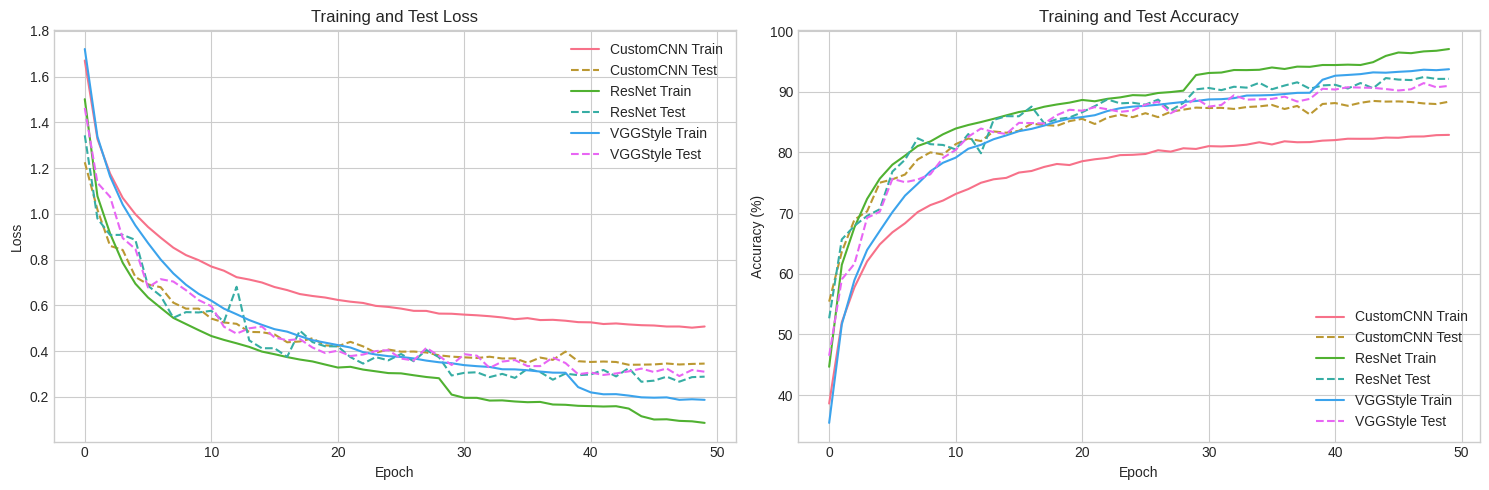

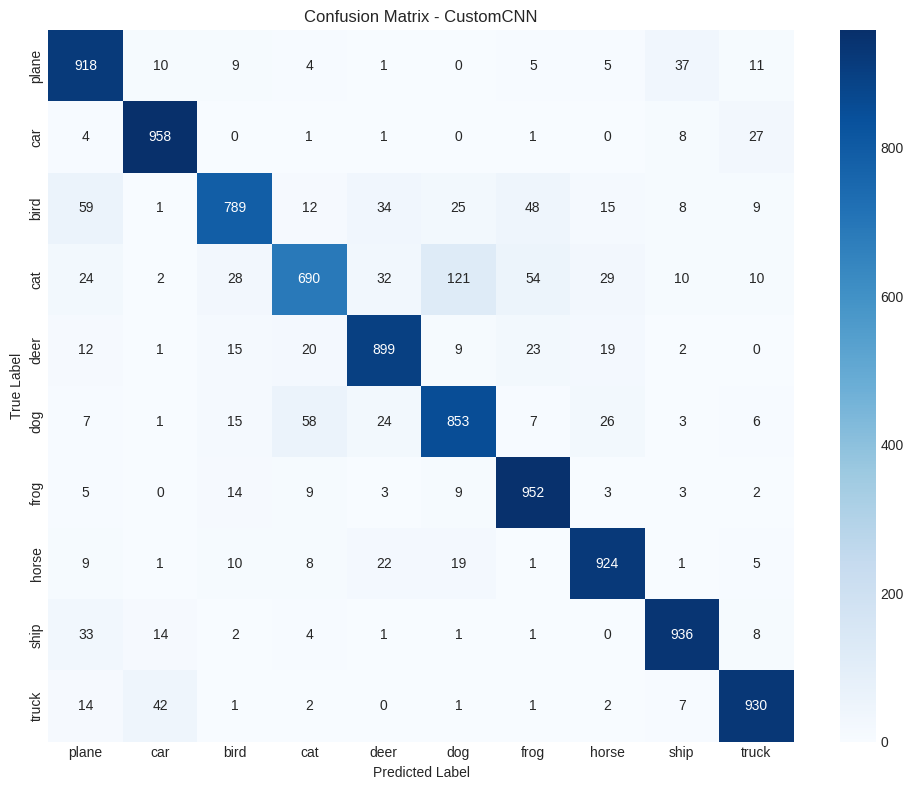


************************************************************
Classification Report - CustomCNN
************************************************************

              precision    recall  f1-score   support

       plane     0.8461    0.9180    0.8806      1000
         car     0.9301    0.9580    0.9438      1000
        bird     0.8935    0.7890    0.8380      1000
         cat     0.8540    0.6900    0.7633      1000
        deer     0.8840    0.8990    0.8914      1000
         dog     0.8218    0.8530    0.8371      1000
        frog     0.8710    0.9520    0.9097      1000
       horse     0.9032    0.9240    0.9135      1000
        ship     0.9222    0.9360    0.9290      1000
       truck     0.9226    0.9300    0.9263      1000

    accuracy                         0.8849     10000
   macro avg     0.8848    0.8849    0.8833     10000
weighted avg     0.8848    0.8849    0.8833     10000



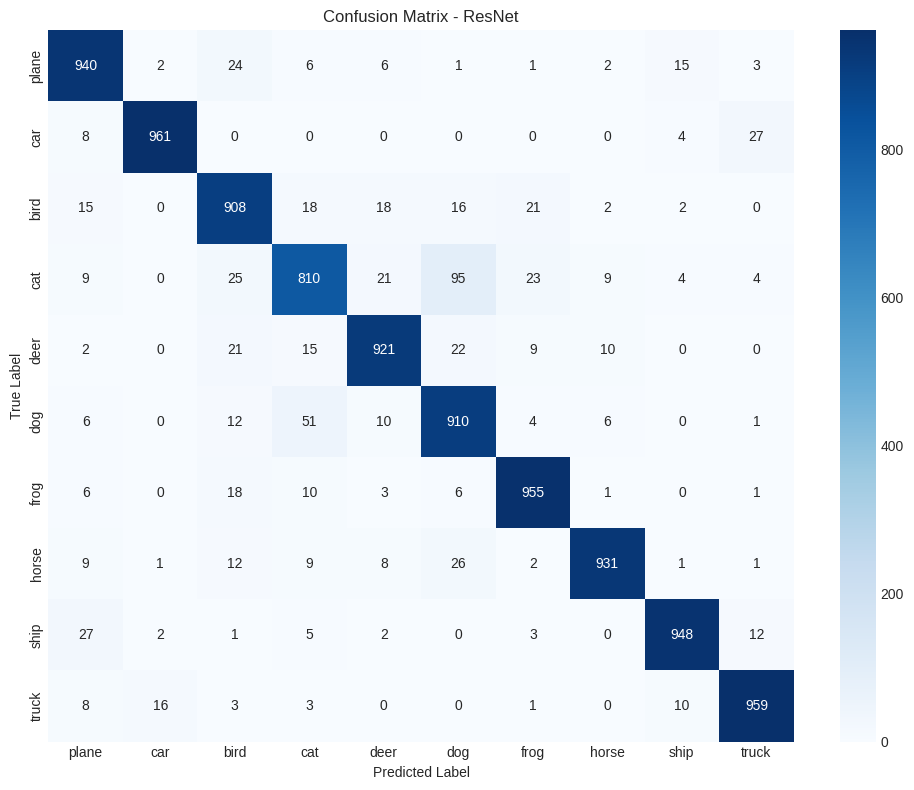


************************************************************
Classification Report - ResNet
************************************************************

              precision    recall  f1-score   support

       plane     0.9126    0.9400    0.9261      1000
         car     0.9786    0.9610    0.9697      1000
        bird     0.8867    0.9080    0.8972      1000
         cat     0.8738    0.8100    0.8407      1000
        deer     0.9312    0.9210    0.9261      1000
         dog     0.8457    0.9100    0.8767      1000
        frog     0.9372    0.9550    0.9460      1000
       horse     0.9688    0.9310    0.9495      1000
        ship     0.9634    0.9480    0.9556      1000
       truck     0.9514    0.9590    0.9552      1000

    accuracy                         0.9243     10000
   macro avg     0.9249    0.9243    0.9243     10000
weighted avg     0.9249    0.9243    0.9243     10000



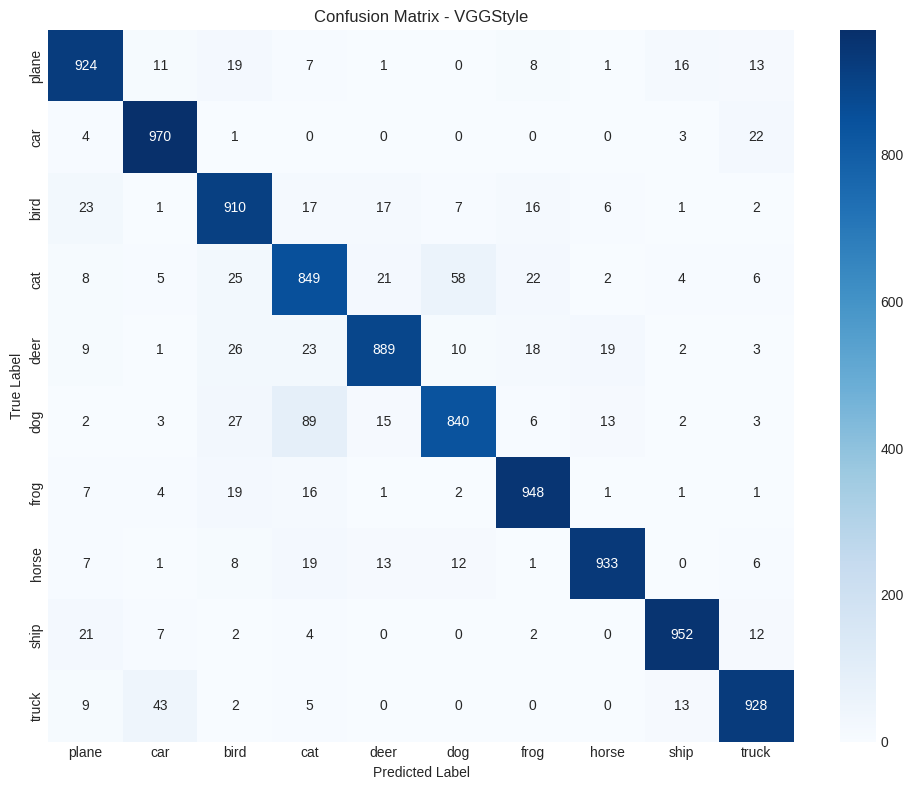


************************************************************
Classification Report - VGGStyle
************************************************************

              precision    recall  f1-score   support

       plane     0.9112    0.9240    0.9176      1000
         car     0.9273    0.9700    0.9482      1000
        bird     0.8758    0.9100    0.8926      1000
         cat     0.8251    0.8490    0.8369      1000
        deer     0.9289    0.8890    0.9085      1000
         dog     0.9042    0.8400    0.8709      1000
        frog     0.9285    0.9480    0.9381      1000
       horse     0.9569    0.9330    0.9448      1000
        ship     0.9577    0.9520    0.9549      1000
       truck     0.9317    0.9280    0.9299      1000

    accuracy                         0.9143     10000
   macro avg     0.9148    0.9143    0.9142     10000
weighted avg     0.9148    0.9143    0.9142     10000



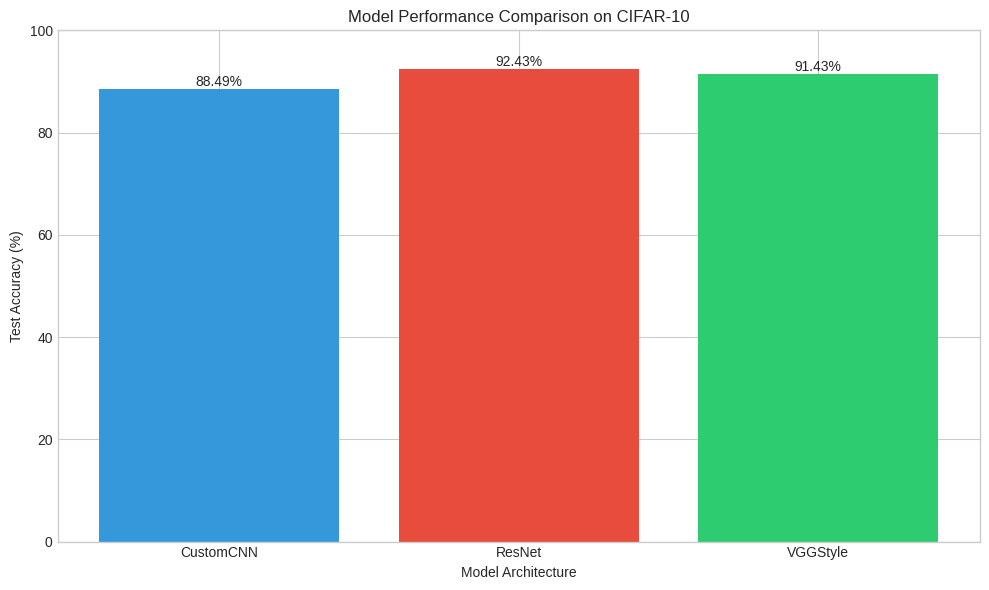


************************************************************
FINAL RESULTS SUMMARY
************************************************************
ResNet         : 92.43%
VGGStyle       : 91.43%
CustomCNN      : 88.49%
************************************************************


In [ ]:
def main():
    """Main execution function"""

    print("*"*60)
    print("CIFAR-10 Multi-Architecture Comparison Study")
    print("*"*60)

    # Load data
    data_loader = CIFAR10DataLoader(batch_size=128)
    train_loader, test_loader = data_loader.load_data()

    # Initialize models
    models = {
        'CustomCNN': CustomCNN(),
        'ResNet': ResNetCIFAR(),
        'VGGStyle': VGGStyleNet()
    }

    # Train all models
    trainers = []
    results = {}

    for name, model in models.items():
        print(f"\n\n{'*'*60}")
        print(f"# Starting {name} Training")
        print(f"{'*'*60}\n")

        trainer = ModelTrainer(model, train_loader, test_loader, name)
        best_acc = trainer.train_model(epochs=50, early_stopping_patience=15)

        trainers.append(trainer)
        results[name] = best_acc

    # Analysis and Visualization
    analyzer = ResultsAnalyzer(data_loader.classes)

    # Plot training history
    analyzer.plot_training_history(trainers)

    # Generate reports for each model
    for trainer in trainers:
        # Load best model
        trainer.model.load_state_dict(
            torch.load(f'{trainer.model_name}_best.pth')
        )

        # Get predictions
        y_true, y_pred = trainer.get_predictions()

        # Generate visualizations and reports
        analyzer.plot_confusion_matrix(y_true, y_pred, trainer.model_name)
        analyzer.generate_classification_report(y_true, y_pred,
                                               trainer.model_name)

    # Compare models
    analyzer.compare_models(results)

    # Print final summary
    print("\n" + "*"*60)
    print("FINAL RESULTS SUMMARY")
    print("*"*60)
    for name, acc in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"{name:15s}: {acc:.2f}%")
    print("*"*60)


if __name__ == "__main__":
    main()

COMPREHENSIVE CIFAR-10 ANALYSIS

Loading test data...
Training samples: 50000
Testing samples: 10000

Extracting predictions from trained models...

  Processing CustomCNN...
  ✓ CustomCNN: 88.49% accuracy

  Processing ResNet...
  ✓ ResNet: 92.43% accuracy

  Processing VGGStyle...
  ✓ VGGStyle: 91.43% accuracy

GENERATING ANALYSES AND VISUALIZATIONS

1. Creating comprehensive comparison...


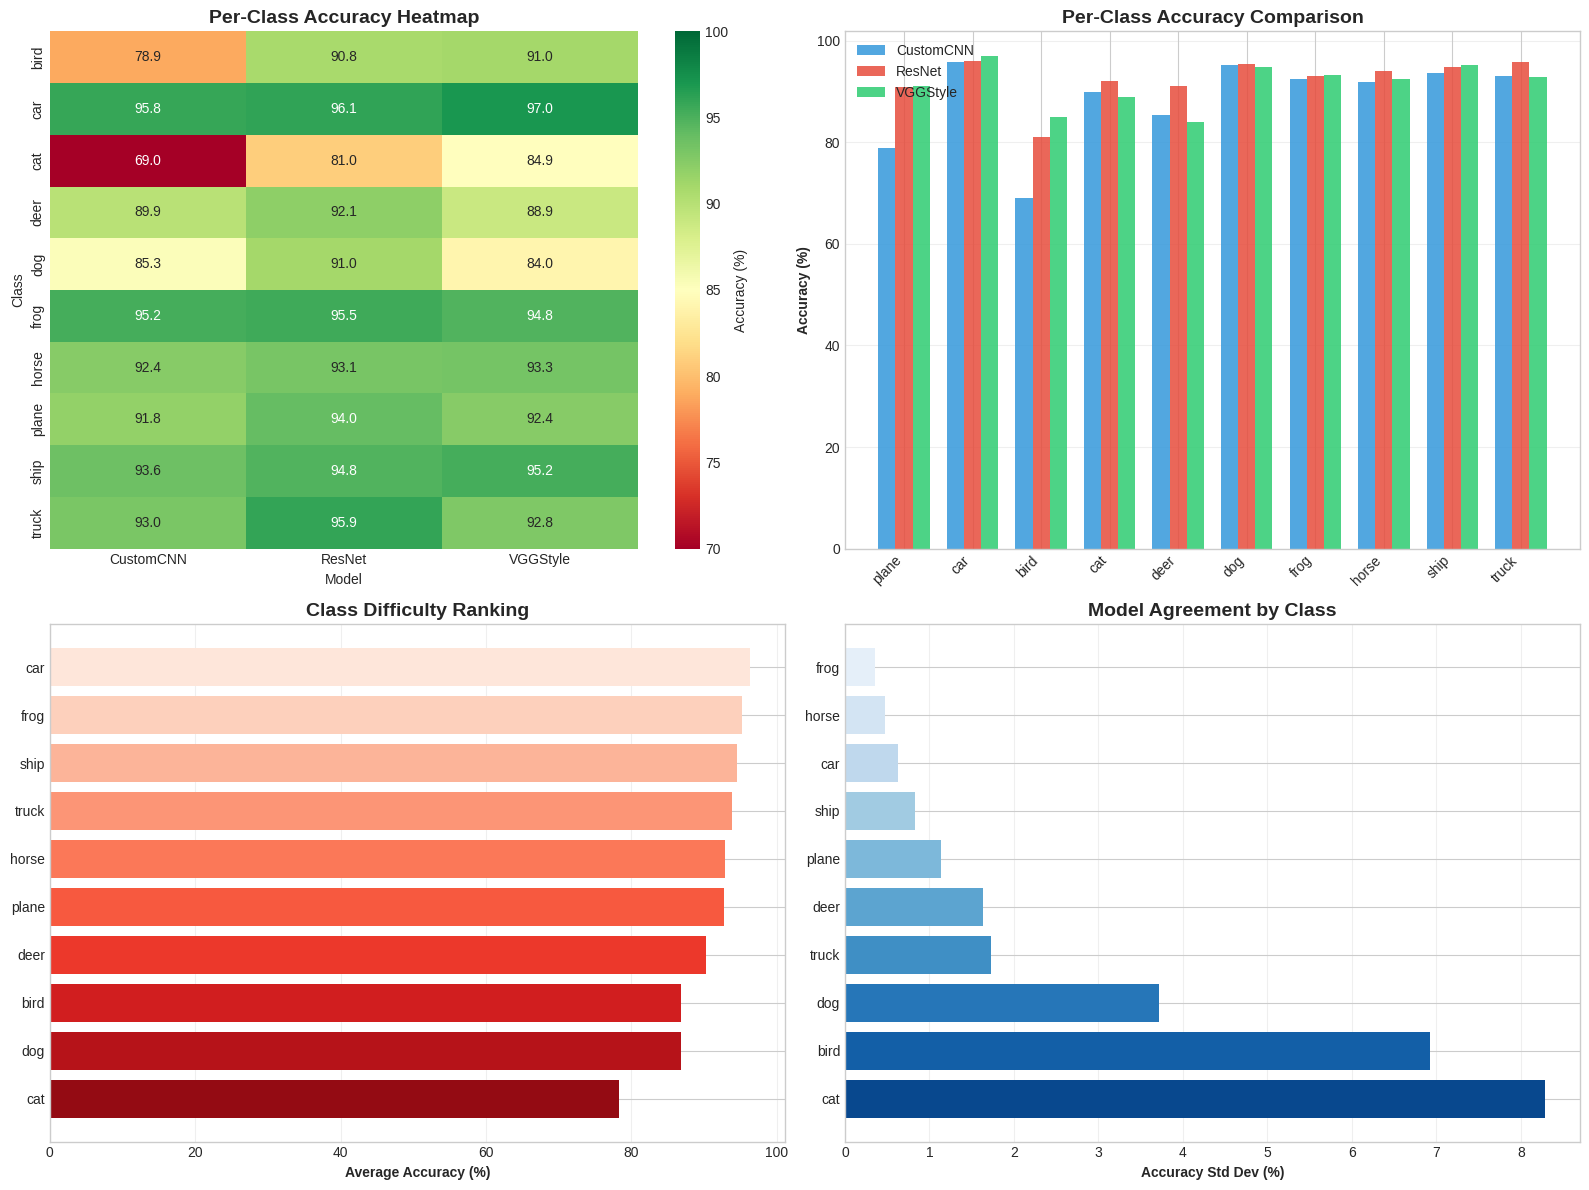


2. Analyzing errors...


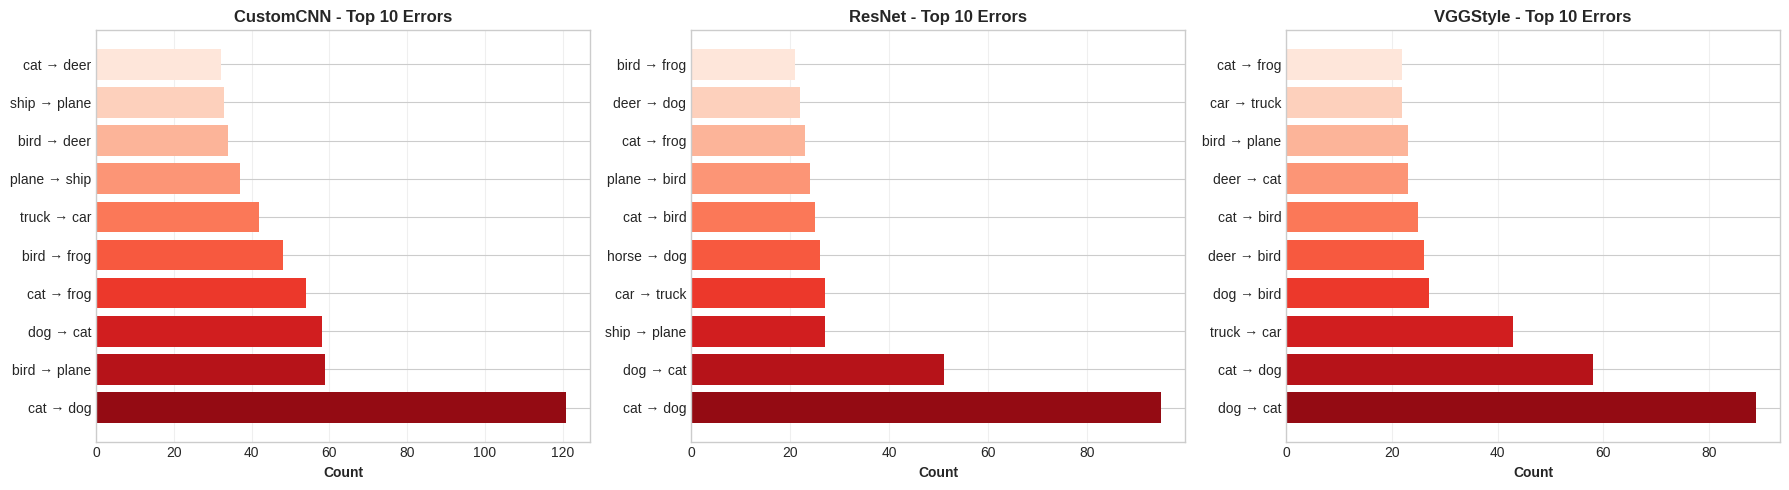


3. Generating ROC curves...


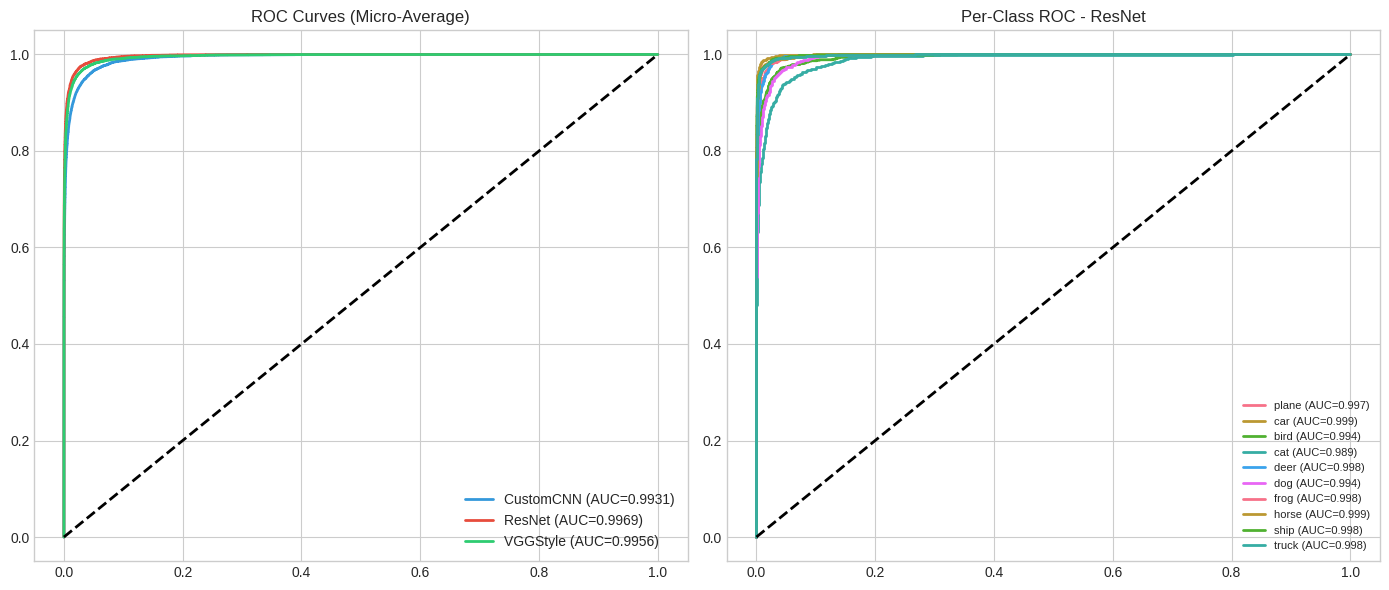


4. Creating summary tables...


,Model,Test Accuracy (%),Best Class (%),Worst Class (%),Variance,Parameters (M),Size (MB)
0,CustomCNN,88.49,95.8,69.0,26.8,3.25,12.41
1,ResNet,92.43,96.1,81.0,15.1,2.78,10.61
2,VGGStyle,91.43,97.0,84.0,13.0,5.87,22.41


Model,CustomCNN,ResNet,VGGStyle
Class,,,
bird,78.9,90.8,91.0
car,95.8,96.1,97.0
cat,69.0,81.0,84.9
deer,89.9,92.1,88.9
dog,85.3,91.0,84.0
frog,95.2,95.5,94.8
horse,92.4,93.1,93.3
plane,91.8,94.0,92.4
ship,93.6,94.8,95.2



Analysis Complete ✅


In [ ]:
# --- Utility functions ---
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def estimate_model_size(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / 1024**2

def get_predictions(model, model_path, test_loader):
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    all_probs, all_preds, all_labels = [], [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            logits = model(x)
            probs = F.softmax(logits, dim=1)
            _, pred = logits.max(1)
            all_probs.append(probs.cpu().numpy())
            all_preds.append(pred.cpu().numpy())
            all_labels.append(y.numpy())
    return np.concatenate(all_labels), np.concatenate(all_preds), np.concatenate(all_probs)

# --- Visualization functions ---
def create_comprehensive_comparison(results_dict, classes):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    comparison_data = []
    for model_name, (y_true, y_pred, _) in results_dict.items():
        for i, cls in enumerate(classes):
            mask = y_true == i
            if mask.sum() > 0:
                acc = (y_pred[mask] == i).sum() / mask.sum() * 100
                comparison_data.append({'Model': model_name, 'Class': cls, 'Accuracy': acc})
    df = pd.DataFrame(comparison_data)
    pivot = df.pivot(index='Class', columns='Model', values='Accuracy')

    # Heatmap
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='RdYlGn', vmin=70, vmax=100,
                ax=axes[0,0], cbar_kws={'label':'Accuracy (%)'})
    axes[0,0].set_title('Per-Class Accuracy Heatmap', fontsize=14, fontweight='bold')

    # Grouped bar
    x = np.arange(len(classes))
    width = 0.25
    colors = ['#3498db','#e74c3c','#2ecc71']
    for i, (model,color) in enumerate(zip(pivot.columns, colors)):
        axes[0,1].bar(x + i*width, pivot[model], width, label=model, color=color, alpha=0.85)
    axes[0,1].set_xticks(x + width)
    axes[0,1].set_xticklabels(classes, rotation=45, ha='right')
    axes[0,1].set_ylabel('Accuracy (%)', fontweight='bold')
    axes[0,1].set_title('Per-Class Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0,1].legend()
    axes[0,1].grid(axis='y', alpha=0.3)

    # Difficulty ranking
    difficulty = pivot.mean(axis=1).sort_values()
    axes[1,0].barh(difficulty.index, difficulty.values, color=sns.color_palette("Reds_r", len(difficulty)))
    axes[1,0].set_xlabel('Average Accuracy (%)', fontweight='bold')
    axes[1,0].set_title('Class Difficulty Ranking', fontsize=14, fontweight='bold')
    axes[1,0].grid(axis='x', alpha=0.3)

    # Model agreement
    variance = pivot.std(axis=1).sort_values(ascending=False)
    axes[1,1].barh(variance.index, variance.values, color=sns.color_palette("Blues_r", len(variance)))
    axes[1,1].set_xlabel('Accuracy Std Dev (%)', fontweight='bold')
    axes[1,1].set_title('Model Agreement by Class', fontsize=14, fontweight='bold')
    axes[1,1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()
    return pivot

def plot_error_analysis(results_dict, classes):
    fig, axes = plt.subplots(1, 3, figsize=(18,5))
    for idx, (model_name, (y_true, y_pred, _)) in enumerate(results_dict.items()):
        errors = [(classes[y_true[i]], classes[y_pred[i]]) for i in range(len(y_true)) if y_true[i] != y_pred[i]]
        error_counts = Counter(errors).most_common(10)
        pairs = [f"{t} → {p}" for (t,p),_ in error_counts]
        counts = [c for _,c in error_counts]
        axes[idx].barh(pairs, counts, color=sns.color_palette("Reds_r", len(pairs)))
        axes[idx].set_title(f"{model_name} - Top 10 Errors", fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Count', fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_roc_curves(probs_dict, y_true, classes):
    n_classes = len(classes)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    fig, axes = plt.subplots(1,2,figsize=(14,6))
    colors = {'CustomCNN':'#3498db','ResNet':'#e74c3c','VGGStyle':'#2ecc71'}

    for model_name, y_probs in probs_dict.items():
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
        roc_auc = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, color=colors[model_name], lw=2, label=f"{model_name} (AUC={roc_auc:.4f})")
    axes[0].plot([0,1],[0,1],'k--',lw=2)
    axes[0].set_title('ROC Curves (Micro-Average)')
    axes[0].legend(loc='lower right')

    best_model = max(probs_dict.keys(), key=lambda k:(y_true==np.argmax(probs_dict[k],axis=1)).mean())
    for i in range(n_classes):
        fpr,tpr,_ = roc_curve(y_true_bin[:,i], probs_dict[best_model][:,i])
        roc_auc = auc(fpr,tpr)
        axes[1].plot(fpr,tpr,lw=2,label=f"{classes[i]} (AUC={roc_auc:.3f})")
    axes[1].plot([0,1],[0,1],'k--',lw=2)
    axes[1].set_title(f'Per-Class ROC - {best_model}')
    axes[1].legend(fontsize=8,loc='lower right')
    plt.tight_layout()
    plt.show()

def create_summary_tables(results_dict, models_dict, classes):
    perf_data = []
    for model_name, (y_true, y_pred, y_probs) in results_dict.items():
        acc = (y_true == y_pred).mean() * 100
        class_accs = [(y_pred[y_true==i]==i).mean()*100 for i in range(len(classes))]
        perf_data.append({
            'Model': model_name,
            'Test Accuracy (%)': acc,
            'Best Class (%)': np.nanmax(class_accs),
            'Worst Class (%)': np.nanmin(class_accs),
            'Variance': np.nanmax(class_accs)-np.nanmin(class_accs),
            'Parameters (M)': count_parameters(models_dict[model_name])/1e6,
            'Size (MB)': estimate_model_size(models_dict[model_name])
        })
    perf_df = pd.DataFrame(perf_data)
    display(perf_df.round(2))

    # Per-class pivot
    class_rows=[]
    for model_name,(y_true,y_pred,_) in results_dict.items():
        for i,cls in enumerate(classes):
            mask=y_true==i
            if mask.sum()>0:
                acc=(y_pred[mask]==i).sum()/mask.sum()*100
                class_rows.append({'Model':model_name,'Class':cls,'Accuracy (%)':acc})
    class_df=pd.DataFrame(class_rows)
    pivot=class_df.pivot(index='Class',columns='Model',values='Accuracy (%)')
    display(pivot.round(2))
    return perf_df,pivot

# --- Main function ---
def run_full_analysis():
    print("="*80)
    print("COMPREHENSIVE CIFAR-10 ANALYSIS")
    print("="*80)
    classes=('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

    print("\nLoading test data...")
    test_loader = CIFAR10DataLoader(batch_size=128).load_data()[1]

    models_dict={'CustomCNN':CustomCNN(),'ResNet':ResNetCIFAR(),'VGGStyle':VGGStyleNet()}
    results_dict, probs_dict = {}, {}

    print("\nExtracting predictions from trained models...")
    for name,model in models_dict.items():
        try:
            print(f"\n  Processing {name}...")
            y_true,y_pred,y_probs = get_predictions(model,f"{name}_best.pth",test_loader)
            results_dict[name]=(y_true,y_pred,y_probs)
            probs_dict[name]=y_probs
            print(f"  ✓ {name}: {(y_true==y_pred).mean()*100:.2f}% accuracy")
        except FileNotFoundError:
            print(f"  ✗ {name}_best.pth not found. Skipping.")

    if not results_dict:
        print("\n✗ No trained models found. Please train models first.")
        return

    print("\n" + "="*80)
    print("GENERATING ANALYSES AND VISUALIZATIONS")
    print("="*80)

    print("\n1. Creating comprehensive comparison...")
    pivot = create_comprehensive_comparison(results_dict, classes)

    print("\n2. Analyzing errors...")
    plot_error_analysis(results_dict, classes)

    print("\n3. Generating ROC curves...")
    y_true = list(results_dict.values())[0][0]
    plot_roc_curves(probs_dict, y_true, classes)

    print("\n4. Creating summary tables...")
    perf_df, class_df = create_summary_tables(results_dict, models_dict, classes)

    print("\nAnalysis Complete ✅")

# === Run analysis ===
run_full_analysis()